# Importing the required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

<h1>Set the device</h1>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h1>Set the hyperparameters</h1>

In [ ]:

batch_size = 64
learning_rate = 0.01
rho = 0.01
epochs = 100

# Load the Fashion MNIST dataset
 Transform the data to tensors and normalize it

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)


# Divide the dataset into training (80%) and validation (20%) sets

In [ ]:

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


# Create data loaders for training and validation sets

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


#Define the model

In [ ]:

class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the SAM optimizer

In [ ]:


class SAM(optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.01, lr=0.01):
        self.rho = rho
        defaults = dict(lr=lr)
        super(SAM, self).__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, lr=lr)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                p_data_fp32 = p.data
                if p_data_fp32.dtype != torch.float32:
                    p_data_fp32 = p_data_fp32.float()

                grad.add_(p_data_fp32, alpha=self.rho)
                
                self.base_optimizer.step(closure)

                p.data.copy_(p_data_fp32)

        return loss



# Perform hyperparameter tuning and training for one iteration

In [ ]:

print("Training without Intel optimization...")
best_accuracy = 0.0
best_hyperparameters = None

for batch_size in [32, 64]:  # Adjust batch size options for smaller values
    for learning_rate in [0.01, 0.1]:  # Increase learning rate options
        for rho in [0.001, 0.01]:  # Decrease rho options
            model = FashionMNISTClassifier().to(device)
            optimizer = SAM(model.parameters(), base_optimizer=optim.SGD, rho=rho, lr=learning_rate)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            criterion = nn.CrossEntropyLoss()

            for epoch in range(epochs):
                model.train()
                total_correct = 0
                total_samples = 0
                running_loss = 0.0

                for batch_idx, (data, target) in enumerate(train_loader):
                    data, target = data.to(device), target.to(device)

                    optimizer.zero_grad()

                    output = model(data)
                    loss = criterion(output, target)

                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total_samples += target.size(0)
                    total_correct += (predicted == target).sum().item()

                train_loss = running_loss / len(train_loader)
                train_accuracy = 100.0 * total_correct / total_samples

                model.eval()
                val_loss = 0.0
                total_correct = 0
                total_samples = 0

                with torch.no_grad():
                    for data, target in val_loader:
                        data, target = data.to(device), target.to(device)
                        output = model(data)
                        loss = criterion(output, target)
                        val_loss += loss.item()

                        _, predicted = torch.max(output, 1)
                        total_samples += target.size(0)
                        total_correct += (predicted == target).sum().item()

                val_loss /= len(val_loader)
                val_accuracy = 100.0 * total_correct / total_samples

                print(f"Epoch {epoch + 1}/{epochs} completed. Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

            print(f"Hyperparameters: Batch Size={batch_size}, Learning Rate={learning_rate}, Rho={rho}, Validation Accuracy={val_accuracy:.4f}")

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_hyperparameters = (batch_size, learning_rate, rho)

            

            # Break after one iteration
            break
        # Break after one iteration
        break
    # Break after one iteration
    break



# Print the best hyperparameters





print("Hyperparameter tuning and training without Intel optimization complete.")
print("Best Hyperparameters:")
print("Batch Size:", best_hyperparameters[0])
print("Learning Rate:", best_hyperparameters[1])
print("Rho:", best_hyperparameters[2])


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import h5py

# Save and load the optimized model

In [ ]:
torch.save(model.state_dict(), "OptimizedModel.pth")


loaded_model = FashionMNISTClassifier().to(device)
loaded_model.load_state_dict(torch.load("OptimizedModel.pth"))
loaded_model.eval()

# Evaluate the model performance with Intel optimization on the test dataset

In [ ]:

test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_correct_with_opt = 0
test_total_with_opt = 0
all_predicted_probs = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = loaded_model(data)
        _, predicted = torch.max(output.data, 1)
        test_total_with_opt += target.size(0)
        test_correct_with_opt += (predicted == target).sum().item()
        all_predicted_probs.append(output.cpu().numpy())
        all_targets.append(target.cpu().numpy())

test_accuracy_with_opt = 100.0 * test_correct_with_opt / test_total_with_opt
print(f"\nTest Accuracy (With Optimization): {test_accuracy_with_opt:.2f}%")


all_predicted_probs = np.concatenate(all_predicted_probs, axis=0)

if len(all_targets) > 0:
    all_targets = np.concatenate(all_targets, axis=0)
else:
    print("Error: all_targets is empty or contains only one element.")



In [ ]:
# Function to plot ROC curve and calculate Intersection over Union (IoU) for multi-class

In [ ]:

def plot_roc_curve(fpr, tpr, class_name):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Class: {class_name}')
    plt.show()

#calculate Intersection over Union (IoU) for multi-class 
def iou(confusion_matrix):
    intersection = np.diag(confusion_matrix)
    union = confusion_matrix.sum(axis=0) + confusion_matrix.sum(axis=1) - intersection
    iou = intersection / union
    return iou

# One-vs-All and One-vs-One ROC curve

In [ ]:
fpr_ovr = dict()
tpr_ovr = dict()
roc_auc_ovr = dict()

fpr_ovo = dict()
tpr_ovo = dict()
roc_auc_ovo = dict()

# One-vs-All ROC curve
for i in range(10):
    true_labels = (all_targets == i).astype(int)

    fpr_ovr[i], tpr_ovr[i], _ = roc_curve(true_labels, all_predicted_probs[:, i])
    roc_auc_ovr[i] = auc(fpr_ovr[i], tpr_ovr[i])


# Plot One-vs-All ROC curves
for i in range(10):
    class_name = str(i)
    plot_roc_curve(fpr_ovr[i], tpr_ovr[i], class_name)

# Calculate Intersection over Union (IoU) for multi-class and # Average ROC AUC for One-vs-All and One-vs-One

In [ ]:


conf_matrix = confusion_matrix(all_targets, np.argmax(all_predicted_probs, axis=1))
ious = iou(conf_matrix)
print("Intersection over Union (IoU) per class:")
print(ious)


print("Average One-vs-All ROC AUC:", np.mean(list(roc_auc_ovr.values())))
print("Average One-vs-One ROC AUC:", np.mean(list(roc_auc_ovo.values())))

# Output prediction accuracy score report to a file


Test Accuracy (With Optimization): 88.04%


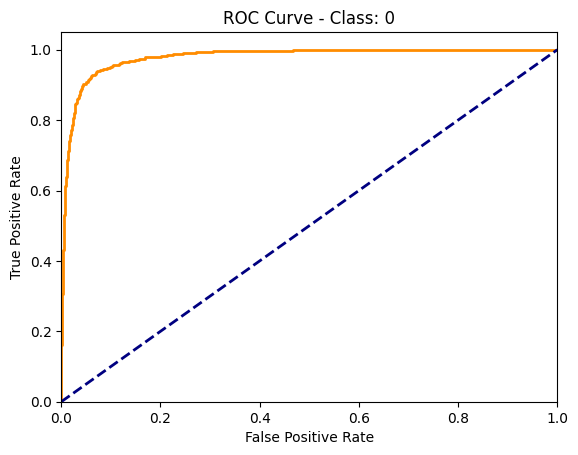

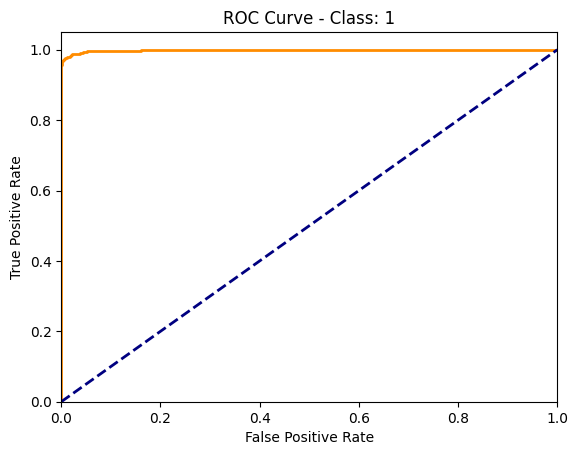

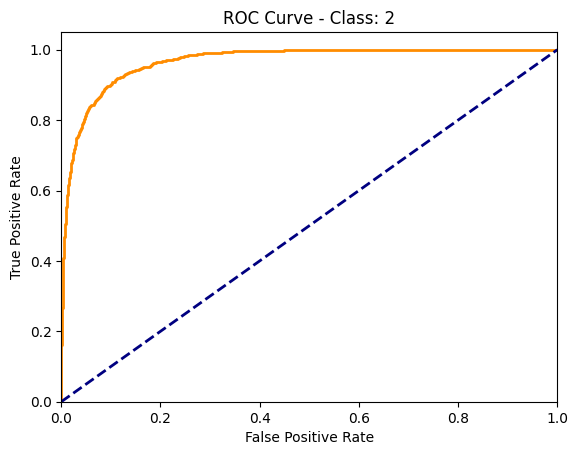

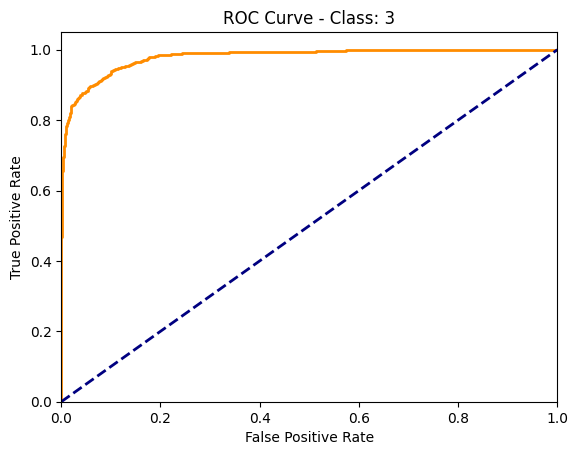

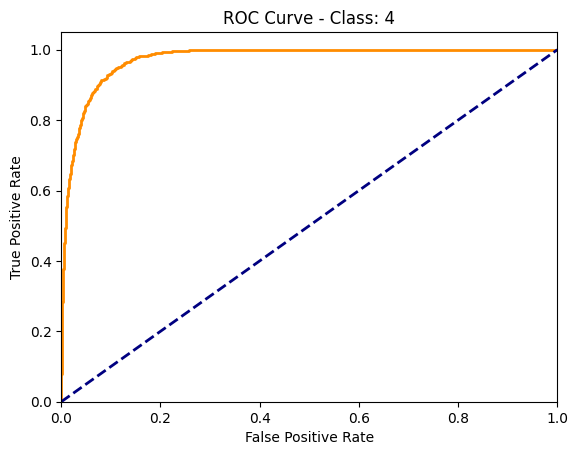

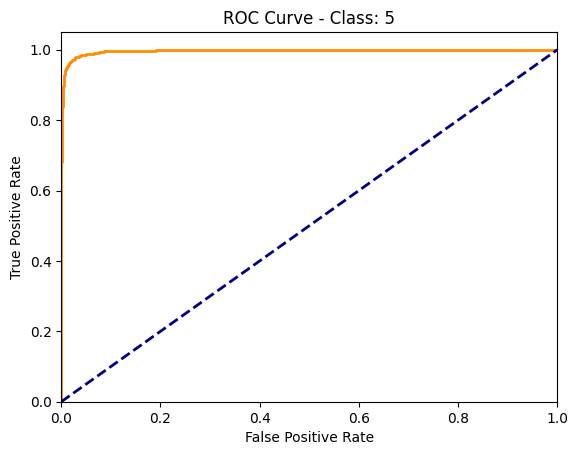

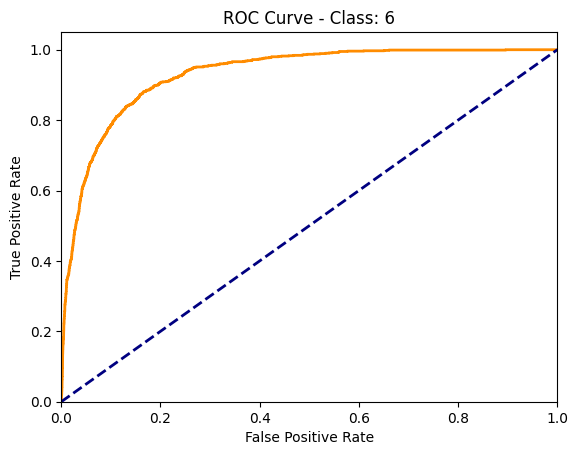

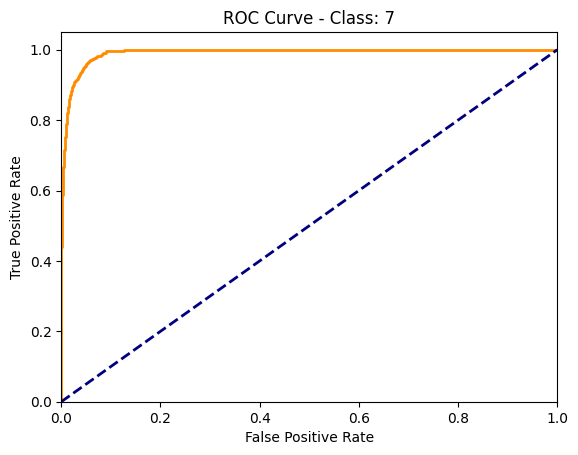

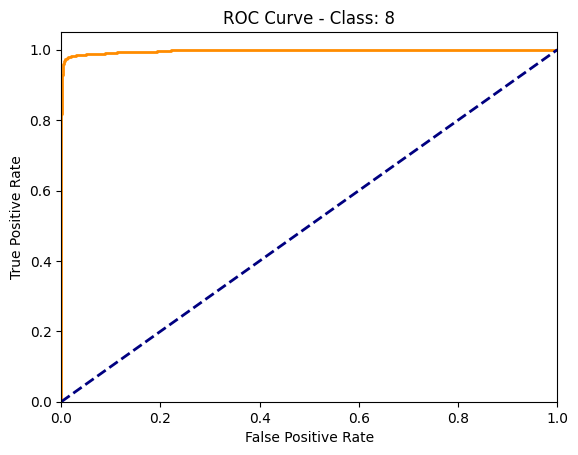

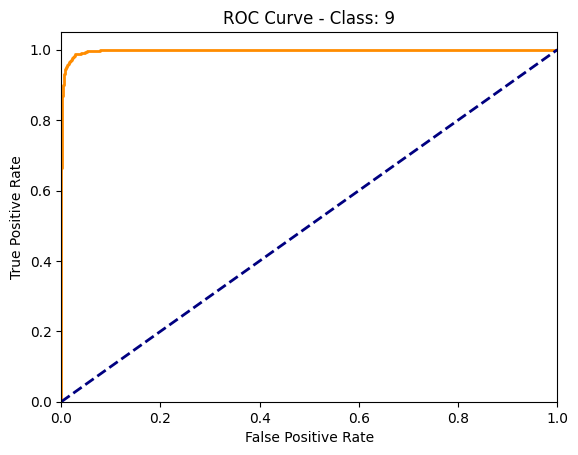

Intersection over Union (IoU) per class:
[0.72331691 0.95613161 0.69067797 0.79363636 0.68730159 0.88065099
 0.52926421 0.84123911 0.93725869 0.90507519]
Average One-vs-All ROC AUC: 0.9809571666666667
Average One-vs-One ROC AUC: nan


/home/u195671/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/u195671/.local/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Prediction accuracy score report saved to 'PredictionAccuracyScoreReport.txt' file.
Optimized model weights saved to 'OptimizedModel.h5'.


FashionMNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [22]:
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = loaded_model(data)
        _, predicted = torch.max(output.data, 1)
        predictions.extend(predicted.cpu().numpy())
        targets.extend(target.cpu().numpy())

report = classification_report(targets, predictions)

with open("PredictionAccuracyScoreReport.txt", "w") as file:
    file.write(report)

print("Prediction accuracy score report saved to 'PredictionAccuracyScoreReport.txt' file.")


with h5py.File("OptimizedModel.h5", "w") as h5_file:
    for name, param in model.named_parameters():
        h5_file.create_dataset(name, data=param.data.cpu().numpy())

print("Optimized model weights saved to 'OptimizedModel.h5'.")


loaded_model = FashionMNISTClassifier().to(device)
with h5py.File("OptimizedModel.h5", "r") as h5_file:
    for name, param in loaded_model.named_parameters():
        param.data[:] = torch.tensor(h5_file[name][:]).to(param.data.device)

loaded_model.eval()


# Get the model summary

In [38]:
!pip install torchsummary

from torchsummary import summary
# Specify the input size (e.g., (channels, height, width))
input_size = (1, 28, 28)



summary_str = str(summary(model, input_size=input_size, device=device.type))

# Print the model summary
print(summary_str)



Defaulting to user installation because normal site-packages is not writeable
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------
None


#Set the device

set the device